## **📘 Notebook 1 – Introduction to Transfer Learning**

---

### **0. Overview and Learning Goals**

In this notebook, we take our first deep dive into **transfer learning** — a powerful idea that allows us to reuse pretrained deep networks instead of training from scratch.

Training deep convolutional networks from the ground up typically requires **millions of labeled images** and extensive compute resources. In contrast, pretrained models like *ResNet* have already learned general-purpose visual features (edges, textures, patterns) from massive datasets such as ImageNet. We can leverage these features for new tasks where data is limited — this is the essence of transfer learning.

In this notebook, we will:

- **Load a pretrained CNN** (ResNet18 trained on ImageNet).
- **Freeze** its feature extraction layers to preserve learned representations.
- **Replace** the final classifier head to match our 10-category Caltech subset.
- **Visualize and interpret** what pretrained models have already learned.
- **Run a zero-shot forward pass** to see how the model behaves “out-of-the-box.”

> The emphasis here is on **understanding concepts**, **examining features**, and **establishing a transfer learning pipeline**.  
> We will *not* train or fine-tune the network yet — that will come in NB02 and NB03.

Before we begin, let’s ensure reproducibility and consistent device setup.


In [1]:
# Reproducibility setup (same pattern used across projects)
import torch, random, numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[info] Using device: {device}")
print(f"[info] Random seed fixed at {SEED}")


[info] Using device: cpu
[info] Random seed fixed at 42


---

### **1. The Intuition Behind Transfer Learning**

When we train a deep convolutional neural network (CNN) from scratch, the model gradually learns to detect increasingly complex visual features:

- **Early layers** capture low-level patterns such as **edges**, **color gradients**, and **simple textures**.  
- **Middle layers** combine those primitives into **shapes** and **object parts**.  
- **Deeper layers** capture **high-level concepts** like faces, animals, or tools.

This hierarchical learning structure means that **the early layers are general-purpose**, useful across many visual tasks — while **the later layers become specialized** for the dataset they were trained on (e.g., ImageNet).

> Think of it like human learning: once we learn to recognize basic shapes (circles, rectangles), we can easily recognize new objects that combine them — learning to spot *trucks* becomes easier once we already know *cars*.

Because of this, we rarely need to train a CNN from scratch. Instead, we:
1. **Reuse (freeze)** the generic, pretrained convolutional layers that already extract useful visual features.
2. **Replace (train)** only the final classifier head for our specific task.

The benefits are substantial:
- **Faster convergence** — fewer parameters to train.
- **Lower data requirements** — we can work with small datasets.
- **Better generalization** — pretrained filters already encode rich, transferable visual knowledge.

However, we must be careful about **domain shift**.  
If our new dataset (e.g., plant leaves or medical scans) is very different from the original (e.g., natural photos), the pretrained features might not transfer perfectly — requiring partial fine-tuning or new adaptation strategies.

We will see these ideas in action by visualizing how pretrained networks “see” the world in upcoming sections.


---

### **2. Dataset Overview: Caltech-101 Ten-Class Teaching Subset**

Before diving into pretrained models, we first familiarize ourselves with the dataset we’ll be using.

We will work with a **10-class subset** of the **Caltech-101 dataset**, curated specifically for teaching and lightweight CPU experimentation.  
This subset contains:

- 10 diverse categories: **airplanes, chair, motorbike, watch, camera, butterfly, faces, lotus, panda, laptop**  
- Around **200–300 images per class**, capped for consistency  
- Images resized to **128 × 128** for efficient processing  
- Pre-split into **train / validation / test (70 % / 15 % / 15 %)**

This subset strikes a balance between **diversity** and **practicality** — it allows us to run deep learning experiments on ordinary hardware while retaining enough visual variety to explore meaningful transfer learning behavior.

> We will first inspect the manifest and verify that the splits and file structure are consistent, then visualize a small grid of images to get an intuitive feel for the data.


**Verify and Summarize the Dataset**

In [28]:
import os, json, pandas as pd
from pathlib import Path

# Dataset paths (generated by the prep cell earlier)
DATA_ROOT = Path("./data/caltech101_10")
MANIFEST = DATA_ROOT / "manifest.csv"
CLASS_NAMES_JSON = DATA_ROOT / "class_names.json"

# Basic checks
assert DATA_ROOT.exists(), f"Dataset folder not found at {DATA_ROOT}"
assert MANIFEST.exists() and CLASS_NAMES_JSON.exists(), "Manifest or class_names.json missing"

# Load metadata
df = pd.read_csv(MANIFEST)
with open(CLASS_NAMES_JSON, "r", encoding="utf-8") as f:
    class_names = json.load(f)

print(f"[info] Found {len(df)} total images")
print(f"[info] Class names ({len(class_names)}): {class_names}")

# Summary by split
print("\n[summary] Images per split:")
print(df["split"].value_counts())

# Per-class per-split counts
counts = df.groupby(["split", "class_name"]).size().unstack(fill_value=0)
print("\n[summary] Per-class counts by split:")
display(counts)

# Check for any missing files
missing = [p for p in df["filepath"] if not Path(p).exists()]
print(f"\n[check] Missing files: {len(missing)} (should be 0)")


[info] Found 1377 total images
[info] Class names (10): ['airplanes', 'chair', 'Motorbikes', 'watch', 'camera', 'butterfly', 'Faces', 'lotus', 'panda', 'laptop']

[summary] Images per split:
split
train    964
val      209
test     204
Name: count, dtype: int64

[summary] Per-class counts by split:


class_name,Faces,Motorbikes,airplanes,butterfly,camera,chair,laptop,lotus,panda,watch
split,,,,,,,,,,
test,37,37,37,13,7,10,12,10,5,36
train,175,175,175,64,35,43,57,46,27,167
val,38,38,38,14,8,9,12,10,6,36



[check] Missing files: 0 (should be 0)


**Visualize Sample Images**

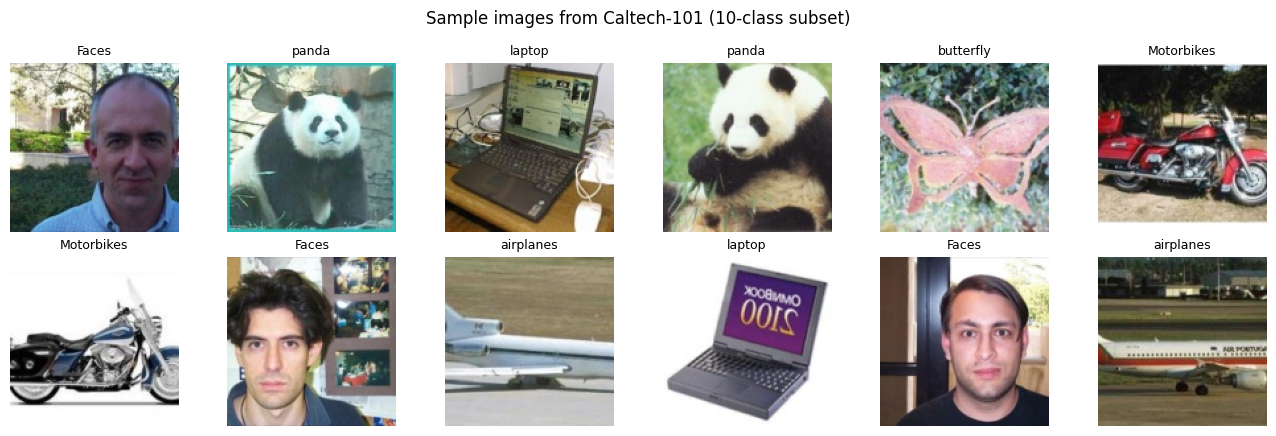

In [3]:
import matplotlib.pyplot as plt
import math
from PIL import Image
from torchvision import transforms

# Basic image loader
tfm_preview = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
])

# Sample a few random training images
sample_df = df[df["split"]=="train"].sample(12, random_state=42).reset_index(drop=True)

cols, rows = 6, 2
plt.figure(figsize=(cols*2.2, rows*2.2))

for i, row in sample_df.iterrows():
    img = Image.open(row["filepath"]).convert("RGB")
    img = tfm_preview(img)
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title(row["class_name"], fontsize=9)
    plt.axis("off")

plt.suptitle("Sample images from Caltech-101 (10-class subset)", fontsize=12)
plt.tight_layout()
plt.show()


By visually inspecting a few samples, we confirm that our curated Caltech-101 subset is diverse and cleanly structured.

Each class exhibits significant **intra-class variation** (different shapes, poses, lighting) — this diversity will be useful when testing how well pretrained features generalize to new categories.

In the next section, we will define consistent **transforms** and **data loaders** that standardize image size, apply normalization, and prepare batches for model input.


---

### **3. Preprocessing and Data Pipelines**

Before we can feed images into a pretrained model, we need to ensure they are transformed into the **format and scale expected by the network**.

Most pretrained CNNs (such as ResNet, VGG, or AlexNet) are trained on **ImageNet**, a large dataset of 1.2 million images. During that training, images were standardized in a specific way:
- resized and cropped to a fixed resolution,
- converted to tensors (values between 0 and 1),
- and **normalized** using the ImageNet dataset statistics.

Formally, each channel of the image tensor (R, G, B) is normalized as:
$$
x' = \frac{x - \mu}{\sigma}
$$
where $\mu$ and $\sigma$ are the channel-wise mean and standard deviation from ImageNet:

$$
\mu = [0.485, 0.456, 0.406], \quad \sigma = [0.229, 0.224, 0.225]
$$

This ensures that inputs to the pretrained model fall within the same scale as those used during pretraining — otherwise, the learned filters would respond incorrectly.

In our case, we will:
1. Resize all images to **128 × 128** (for computational efficiency),
2. Apply `CenterCrop(128)`,
3. Convert to tensors,
4. Normalize using **ImageNet mean and std**.

We will also define **DataLoaders** for the train, validation, and test splits.  
These loaders batch our data, shuffle it (for training), and prepare tensors for the GPU or CPU.  
Finally, we will visualize a mini-batch to confirm that everything works as expected.


**Define Transforms and Constants**

In [4]:
from torchvision import transforms

# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Define the preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

print("[info] Transformation pipeline ready.")

[info] Transformation pipeline ready.


**Build Dataset Objects and DataLoaders**

In [5]:
from torchvision import datasets
from torch.utils.data import DataLoader

# Load dataset from prepared folders
train_dir = DATA_ROOT / "train"
val_dir   = DATA_ROOT / "val"
test_dir  = DATA_ROOT / "test"

train_ds = datasets.ImageFolder(train_dir, transform=transform)
val_ds   = datasets.ImageFolder(val_dir, transform=transform)
test_ds  = datasets.ImageFolder(test_dir, transform=transform)

# DataLoaders (small batch size for CPU runs)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

print(f"[info] Dataset sizes → train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")
print(f"[info] Classes: {train_ds.classes}")


[info] Dataset sizes → train=964, val=209, test=204
[info] Classes: ['Faces', 'Motorbikes', 'airplanes', 'butterfly', 'camera', 'chair', 'laptop', 'lotus', 'panda', 'watch']


**Visualize a Mini-Batch**

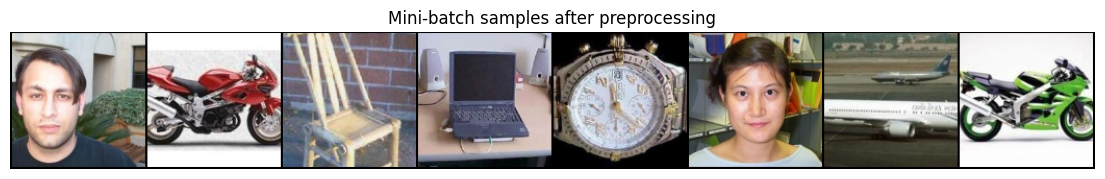

Labels for these samples: ['Faces', 'Motorbikes', 'chair', 'laptop', 'watch', 'Faces', 'airplanes', 'Motorbikes']


In [6]:
import matplotlib.pyplot as plt
import torchvision

# Helper function to unnormalize images for display
def unnormalize(img_tensor):
    img = img_tensor.clone()
    for c, (m, s) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        img[c] = img[c] * s + m
    return img.clamp(0, 1)

# Fetch one mini-batch
images, labels = next(iter(train_loader))

# Unnormalize for display
images_disp = [unnormalize(img) for img in images[:8]]

# Create grid
grid = torchvision.utils.make_grid(images_disp, nrow=8)
plt.figure(figsize=(14, 2.5))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Mini-batch samples after preprocessing")
plt.axis("off")
plt.show()

print(f"Labels for these samples: {[train_ds.classes[i] for i in labels[:8].tolist()]}")


Our preprocessing pipeline now mirrors the ImageNet setup expected by pretrained models.  

This ensures that the pixel intensities and distributions are consistent with what the pretrained filters “expect to see.”  

By inspecting the mini-batch visualization, we verify that images are correctly sized, centered, and normalized.  

We are now ready to load a pretrained model (ResNet18) and adapt it for our Caltech-101 subset.

---

### **4. Loading and Inspecting a Pretrained CNN**

We now load a **pretrained convolutional neural network** (CNN) to understand what transfer learning builds upon.  
In this notebook, we will use **ResNet-18**, a smaller but powerful variant of the *Residual Network* family trained on the **ImageNet** dataset.

ResNet models introduced **skip (residual) connections** that allow gradients to flow more easily through very deep architectures.  
Instead of learning a direct mapping $H(x)$, each residual block learns a *residual function* $F(x) = H(x) - x$, which simplifies optimization.  
The block then outputs:

$$
y = F(x) + x
$$

This additive shortcut helps avoid the **vanishing-gradient problem** and enables much deeper networks to train successfully.

The pretrained **ResNet-18** was trained to classify **1000 ImageNet categories** (from dogs and cats to tools and furniture).  
Its structure consists of:
- An initial **convolutional stem** (Conv–BN–ReLU–Pooling),
- Four **residual stages** that progressively reduce spatial dimensions and increase feature depth,
- A **global average pooling** layer that flattens the spatial map into a feature vector,
- And a final **fully-connected (FC)** layer mapping to 1000 output classes.

By loading the pretrained weights, we inherit knowledge about **edges, textures, and shapes** that were already learned from millions of images.

We will now:
1. Load `torchvision.models.resnet18(weights='IMAGENET1K_V1')`
2. Print a summary of the model’s architecture and parameters.
3. Build intuition for how the depth of the network relates to the level of feature abstraction.


**Load the Pretrained Model**

In [7]:
import torch
from torchvision import models

# Load pretrained ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

print("[info] Pretrained ResNet-18 loaded successfully.")

[info] Pretrained ResNet-18 loaded successfully.


**Inspect the Architecture**

In [13]:
from torchsummary import summary

# Move to CPU (since we are in concept notebook)
device = torch.device("cpu")
model.to(device)

# Display model structure and parameter count
summary(model, input_size=(3, 128, 128))

layer_hierarchy = [name for name, _ in model.named_children()]
print("Top-level children:", layer_hierarchy)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

**Visualize the Layer Hierarchy**

In [9]:
# Show hierarchical layer structure
print(model)

# Quick count of total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n[summary] Total parameters: {total_params:,}")
print(f"[summary] Trainable parameters: {trainable_params:,}")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

By inspecting the printed architecture, we can trace how **ResNet-18** transforms an input image through successive convolutional and residual blocks.

- Early layers detect **edges** and **colors**.  
- Mid-level layers combine them into **shapes** and **object parts**.  
- Deep layers encode **abstract semantic features** such as “animal face” or “wheel.”

The skip connections ($y = F(x) + x$) make training such deep networks feasible, preserving gradient flow even through dozens of layers.  

This pretrained network now acts as a powerful **feature extractor** — in the next section, we will selectively **freeze its layers** and **replace the final classifier** to adapt it for our 10-class Caltech-101 subset.

---

**✅ Code Task 11.1.4.1: Inspect a different pretrained model**

**Student instruction**: Load a specified torchvision model (default: VGG16), move it to CPU, and report (a) total params, (b) trainable params.

In [ ]:
from torchvision import models
import torch

# Use a different pretrained model than ResNet18
CT_model_name = "vgg16"   # you may change to "squeezenet1_1" or "mobilenet_v3_small"
CT_device = torch.device("cpu")

# 1) Load pretrained model
if CT_model_name == "vgg16":
    CT_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
elif CT_model_name == "squeezenet1_1":
    CT_model = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights.IMAGENET1K_V1)
elif CT_model_name == "mobilenet_v3_small":
    CT_model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
else:
    raise ValueError("Unsupported model name")

CT_model = CT_model.to(...)

# 2) Compute parameter counts
CT_total_params = ...
CT_trainable_params = ...

print(f"CT_total_params={...:,}") 
print(f"CT_trainable_params={...:,}")

**Instructor Solution**

In [ ]:
from torchvision import models
import torch

CT_model_name = "vgg16"
CT_device = torch.device("cpu")

if CT_model_name == "vgg16":
    CT_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
elif CT_model_name == "squeezenet1_1":
    CT_model = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights.IMAGENET1K_V1)
elif CT_model_name == "mobilenet_v3_small":
    CT_model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
else:
    raise ValueError("Unsupported model name")

CT_model = CT_model.to(CT_device)

CT_total_params = sum(p.numel() for p in CT_model.parameters())
CT_trainable_params = sum(p.numel() for p in CT_model.parameters() if p.requires_grad)
#CT_first_modules = [name for name, _ in list(CT_model.named_children())[:5]]

print(f"CT_total_params={CT_total_params:,}")
print(f"CT_trainable_params={CT_trainable_params:,}")
#print("CT_first_modules:", CT_first_modules)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\noman/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [03:02<00:00, 3.04MB/s] 


CT_total_params=138,357,544, CT_trainable_params=138,357,544
CT_first_modules: ['features', 'avgpool', 'classifier']


In [ ]:
assert 'CT_model' in globals(), "❌ CT_model not defined."
#assert isinstance(CT_first_modules, list) and len(CT_first_modules) > 0, "❌ CT_first_modules must be a non-empty list."
assert isinstance(CT_total_params, int) and CT_total_params > 0, "❌ CT_total_params must be a positive int."
assert isinstance(CT_trainable_params, int) and CT_trainable_params > 0, "❌ CT_trainable_params must be a positive int."
print("✅ CT_Task 1 checks passed.")

---

**✅ Code Task 11.1.4.2: Inspect the architecture**

**Student instruction**: Inspect the summary of the architecture and create a compact list called CT_layer_hierarchy containing the string names of all top-level children modules for the model you loaded in the last code (do not print the full model).

In [ ]:
# Reuse CT_model from CT_Task 1

# Display model structure and parameter count
summary(..., input_size=(3, 128, 128))

CT_layer_hierarchy = [name for name, _ in CT_model....()]
print("Top-level children:", ...)

**✅ Instructor solution**

In [ ]:
# Display model structure and parameter count
summary(CT_model, input_size=(3, 128, 128))

CT_layer_hierarchy = [name for name, _ in CT_model.named_children()]
print("Top-level children:", CT_layer_hierarchy)

In [ ]:
assert isinstance(CT_layer_hierarchy, list), "❌ CT_layer_hierarchy must be a list."
assert len(CT_layer_hierarchy) >= 3, "❌ Expect at least 3 top-level children."
assert all(isinstance(x, str) for x in CT_layer_hierarchy), "❌ All entries must be strings."
print("✅ CT_Task 2 checks passed.")

---

### **5. Freezing Layers and Swapping the Classifier Head**

Our goal is to **reuse** the pretrained feature extractor and only learn a **small new classifier** for our 10-class Caltech subset. Practically, we:

1. **Freeze** all pretrained parameters by setting `requires_grad = False`. This preserves the feature extractor as-is and reduces the number of trainable parameters dramatically.
2. **Replace** the final fully-connected (FC) layer with a new head sized to our task: `nn.Linear(\text{in\_features}, 10)`.
3. **Re-initialize** the new head (e.g., Kaiming initialization for ReLU-based networks) so that it starts from a reasonable random state.

Why freeze first? With a small dataset, training the entire network risks **overfitting** and **catastrophic forgetting**. By freezing the backbone and training only the head, we perform **feature extraction**: we map the rich, pretrained features to our class labels efficiently and reliably. In later notebooks, we will **unfreeze upper blocks** and fine-tune carefully with a smaller learning rate to adapt features while protecting what the model already knows.


**Freeze the Pretrained Backbone**

In [14]:
import torch
import torch.nn as nn
from torchvision import models

# Safety: ensure we have a model (from Section 4); otherwise load it
try:
    _ = model
except NameError:
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Move to device (kept CPU-friendly in this NB)
device = torch.device("cpu")
model = model.to(device)

# 1) Freeze all pretrained params
for p in model.parameters():
    p.requires_grad = False

print("[info] Frozen all backbone parameters.")


[info] Frozen all backbone parameters.


**Replace and Initialize the Classifier Head**

In [15]:
import math

# Determine number of classes from our prepared metadata if available; fallback to 10
try:
    num_classes = len(class_names)
except NameError:
    num_classes = 10

# 2) Replace the final FC layer with a new head
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# 3) Kaiming initialization (good default for ReLU nets)
nn.init.kaiming_uniform_(model.fc.weight, a=math.sqrt(5))
if model.fc.bias is not None:
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(model.fc.weight)
    bound = 1 / math.sqrt(fan_in)
    nn.init.uniform_(model.fc.bias, -bound, bound)

model = model.to(device)
model.eval()

print(f"[info] Replaced classifier head: in_features={in_features}, out_features={num_classes}")


[info] Replaced classifier head: in_features=512, out_features=10


**Verify Trainable Parameters Only in the New Head**

In [16]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
trainable_names = [n for n, p in model.named_parameters() if p.requires_grad]

print(f"[summary] Total parameters: {total_params:,}")
print(f"[summary] Trainable parameters (should be only the new head): {trainable_params:,}")
print("[summary] Trainable parameter tensors:")
for n in trainable_names:
    print("  •", n)

# Simple assert (will raise if something other than the new head is trainable)
assert all(n.startswith("fc.") for n in trainable_names), "Unexpected trainable parameters outside the classifier head."
print("[check] Only the classifier head is trainable. Good to proceed.")


[summary] Total parameters: 11,181,642
[summary] Trainable parameters (should be only the new head): 5,130
[summary] Trainable parameter tensors:
  • fc.weight
  • fc.bias
[check] Only the classifier head is trainable. Good to proceed.


We have now **frozen** the pretrained feature extractor and attached a **fresh, randomly initialized head** sized for our labels.  

This setup is ideal for **feature extraction**: we will train only this small head in the next notebook (NB02), which converges fast and requires far fewer examples.  

In NB03, we will explore **controlled fine-tuning** by unfreezing upper layers (e.g., the last residual block) and using a smaller learning rate to adapt features without forgetting.


---

### **6. Zero-Shot Forward Pass and Softmax Predictions**

Now that we have a frozen pretrained feature extractor and a new random classifier head, let’s perform a **zero-shot forward pass**.  
This helps us confirm that the data pipeline and model architecture are working as expected before we begin training.

A **forward pass** means sending input images through the model to compute the output logits — the raw, unnormalized predictions from the final layer.  
In our case, these logits are 10-dimensional (since we have 10 classes).  

To interpret these logits, we apply the **softmax** function:

$$
p_i = \frac{e^{z_i}}{\sum_j e^{z_j}}
$$

where $z_i$ is the logit for class $i$ and $p_i$ is its corresponding predicted probability.  
Softmax converts arbitrary logits into a probability distribution that sums to 1 across all classes.

Because our new classifier head is **randomly initialized**, these predictions are effectively **random guesses**.  
However, this step is pedagogically important — it ensures:
- The model receives data of the right shape,
- The forward computation works correctly,
- The output dimensionality matches the number of classes.

Once we confirm this, we’ll be ready to implement a proper **training loop** in the next notebook (NB02).


**Run a Zero-Shot Forward Pass**

In [17]:
import torch.nn.functional as F

# Fetch one mini-batch from the validation loader
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

# Run through the frozen model (no grad tracking)
with torch.no_grad():
    logits = model(images)
    probs = F.softmax(logits, dim=1)

print(f"[check] Logits shape: {logits.shape}")
print(f"[check] Probabilities shape: {probs.shape}")

[check] Logits shape: torch.Size([32, 10])
[check] Probabilities shape: torch.Size([32, 10])


**Inspect Predictions for a Few Samples**

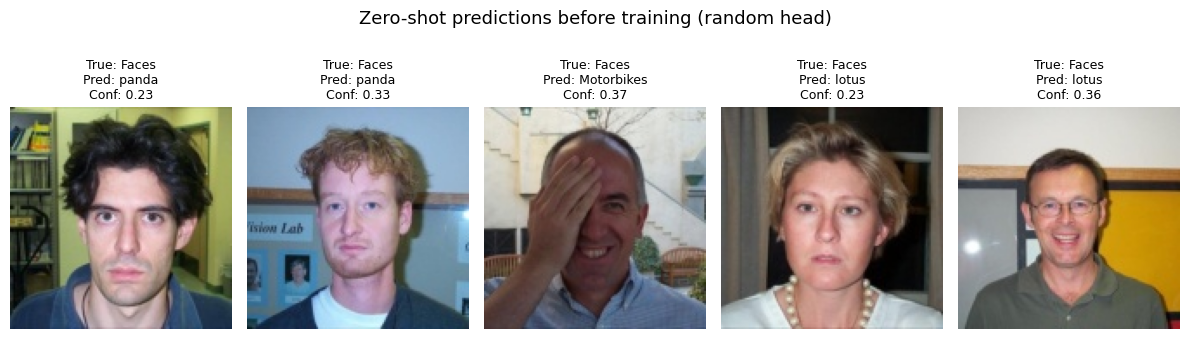

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Pick 5 random samples from the batch
idxs = np.random.choice(len(images), size=5, replace=False)

plt.figure(figsize=(12, 4))
for i, idx in enumerate(idxs):
    img = images[idx].cpu()
    label = labels[idx].item()
    pred_class = torch.argmax(probs[idx]).item()
    confidence = probs[idx][pred_class].item()

    # Unnormalize image for display
    img_disp = img.clone()
    for c, (m, s) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        img_disp[c] = img_disp[c] * s + m

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_disp.permute(1, 2, 0).clamp(0, 1))
    plt.axis("off")
    plt.title(
        f"True: {train_ds.classes[label]}\nPred: {train_ds.classes[pred_class]}\nConf: {confidence:.2f}",
        fontsize=9,
    )

plt.suptitle("Zero-shot predictions before training (random head)", fontsize=13)
plt.tight_layout()
plt.show()


Even though our current predictions look random, this test confirms that the **entire model pipeline** — from data loading to forward computation — is functioning correctly.  

- The output layer produces logits of size 10 (matching our classes).  
- The softmax converts them into valid probabilities.  
- No errors occur in batching, device placement, or data normalization.

This means we are ready to proceed with **training the classifier head** in the next notebook.  

In NB02, we’ll introduce a proper training loop, define loss functions, and observe how the pretrained features allow the new head to learn rapidly — even with limited data.


---

### **7. Peeking Inside: What Pretrained Models Learn**

To truly appreciate **transfer learning**, we need to understand *what* pretrained models actually learn from large datasets such as ImageNet.

Convolutional neural networks (CNNs) build a **hierarchy of features** as we move deeper through the layers:

- **Early layers** learn to detect very simple patterns — **edges**, **color gradients**, and **oriented lines**.  
  These are like the “visual alphabet” of deep learning: universal primitives found in almost any image.
- **Middle layers** start combining these primitives into more complex **shapes**, **textures**, and **object parts** — for example, curves, corners, or repeating patterns.
- **Deeper layers** assemble those into **object-level concepts** such as “face,” “wheel,” or “wing,” which carry strong semantic meaning.

This gradual composition from simple to abstract is what makes deep convolutional networks so powerful.  
It also explains why **transfer learning works** — early features learned from ImageNet are general enough to be reused in many different domains.

We will visualize two aspects:

1. **First-layer filters:** what patterns the model’s very first convolutional kernels are sensitive to.
2. **Intermediate feature maps:** how an input image is transformed inside the network at different depths.

These visualizations will help us *see* the learning hierarchy in action.


**Visualize the First Convolutional Layer Filters**

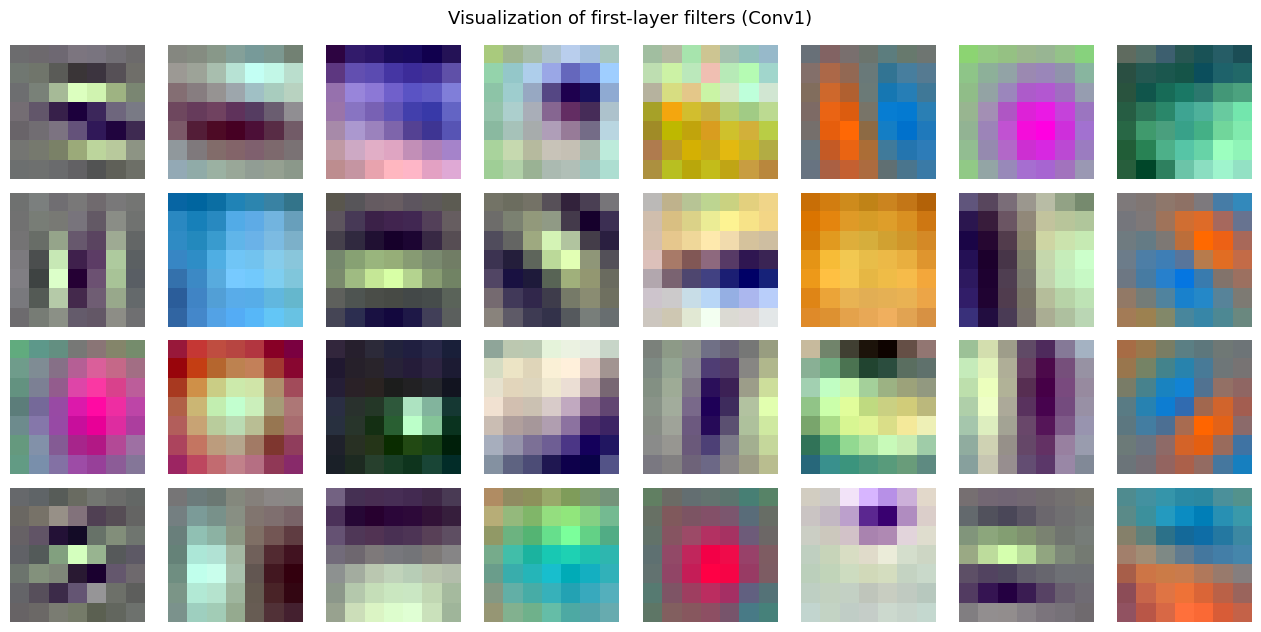

In [19]:
import matplotlib.pyplot as plt

# Visualize a few filters
filters = model.conv1.weight.detach().cpu()
num_filters = 32
cols = 8
rows = num_filters // cols

plt.figure(figsize=(cols * 1.6, rows * 1.6))
for i in range(num_filters):
    f = filters[i]
    f = (f - f.min()) / (f.max() - f.min())  # normalize for display
    plt.subplot(rows, cols, i + 1)    
    plt.imshow(f.permute(1,2,0))
    plt.axis("off")
plt.suptitle("Visualization of first-layer filters (Conv1)", fontsize=13)
plt.tight_layout()
plt.show()

> These filters are the *learned visual primitives* of a pretrained ResNet18 network trained on ImageNet.  
> Each colored square represents a $7 \times 7$ filter in the first convolutional layer that detects simple visual cues such as **edges, gradients, and color transitions**.  
> 
> We can think of them as “reusable feature detectors” — building blocks that will later combine to detect complex textures, patterns, and objects.  
> This layer learns to identify **generic low-level features** that are not specific to any one dataset, which explains why pretrained CNNs often transfer well to new image domains.

**Visualizing pretrained filter responses on a real image**
- Step 1: Show the input image
- Step 2: Visualize how the first conv layer (Conv1) responds to it

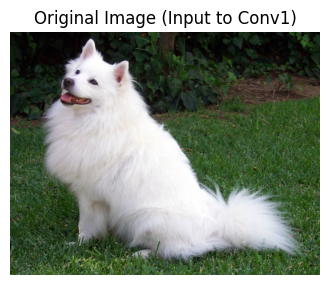

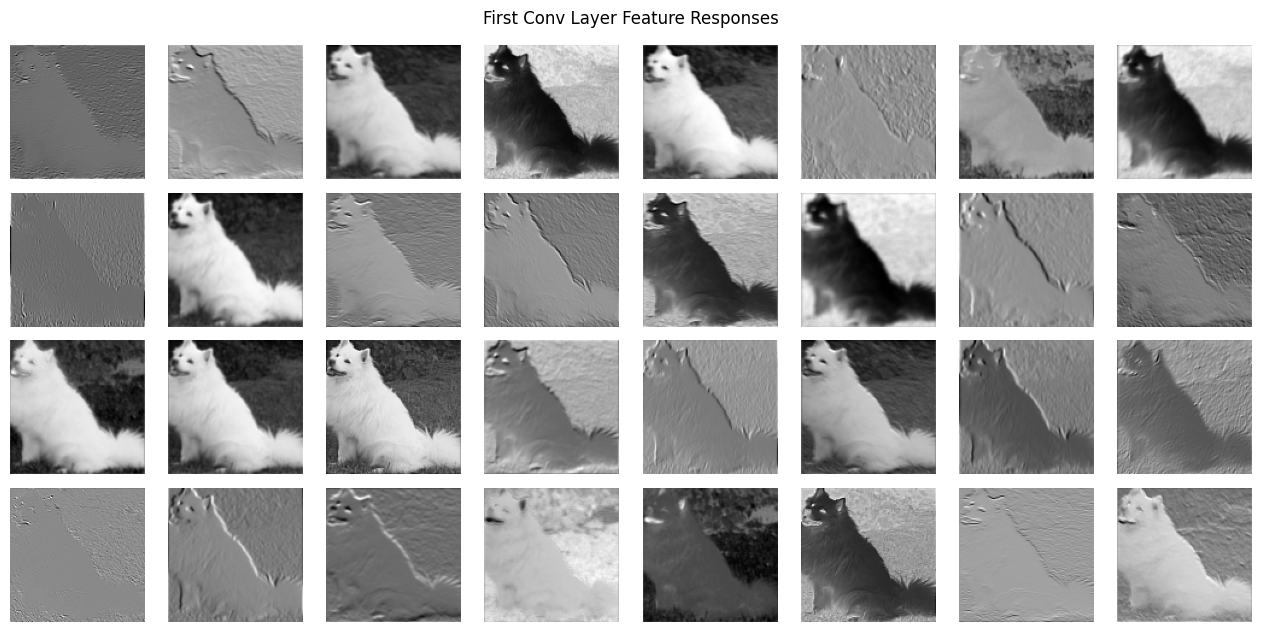

In [ ]:
import requests
# --- Step 1: Load and show a real image ---
url = "https://pytorch.org/assets/images/dog.jpg"
img = Image.open(requests.get(url, stream=True).raw)

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.title("Original Image (Input to Conv1)")
plt.axis("off")
plt.show()

# --- Step 2: Preprocess and run through Conv1 ---
weights = models.ResNet18_Weights.IMAGENET1K_V1   # keep this reference for transforms
preprocess = weights.transforms()           # correct: use the transforms defined by weights
x = preprocess(img).unsqueeze(0)

with torch.no_grad():
    feat = model.conv1(x)[0]  # [C,H,W] feature maps


# --- Step 3: Visualize a few feature responses ---
plt.figure(figsize=(cols * 1.6, rows * 1.6))
for i in range(num_filters):
    plt.subplot(rows, cols, i + 1)    
    plt.imshow(feat[i].cpu(), cmap="gray")
    plt.axis("off")

plt.suptitle("First Conv Layer Feature Responses", fontsize=12)
plt.tight_layout()
plt.show()

Here, we can see how these filters respond when applied to a real image.  

Each gray-scale map represents the *activation output* of one filter — essentially showing **which parts of the image strongly match that filter’s pattern**.  

> Notice how some filters activate around **edges** (e.g., the outline of the dog), while others capture **texture or brightness contrasts** (e.g., fur and background separation).  
> This illustrates how convolutional layers progressively build a hierarchical understanding of an image — starting from **edges and gradients** in early layers to **shapes and objects** in deeper ones.

**Even though the **first-layer filters** appear colorful, the **feature responses** we see here are shown in **grayscale**. Why?** 

Each filter in the first convolutional layer has **3 color channels (RGB)**, so when we visualize the filter itself, it looks colorful — it represents *how the model combines colors* to detect specific low-level patterns such as edges or color transitions.  

When the image passes through these filters, each one produces a **single activation map** — a 2D array showing *how strongly that filter fires* at each spatial location.  

These activation maps are **single-channel** intensity values (not colors), so we display them as **grayscale images**.  
 
In essence:
> - **Colorful filters** → show *what kind of visual patterns* each filter is tuned to detect.  
> - **Grayscale responses** → show *where and how strongly* those patterns appear in the input image.  
 
> This visualization helps us grasp how CNNs begin to transform pixel-level color data into meaningful **feature activations**, which later layers combine into higher-level representations.


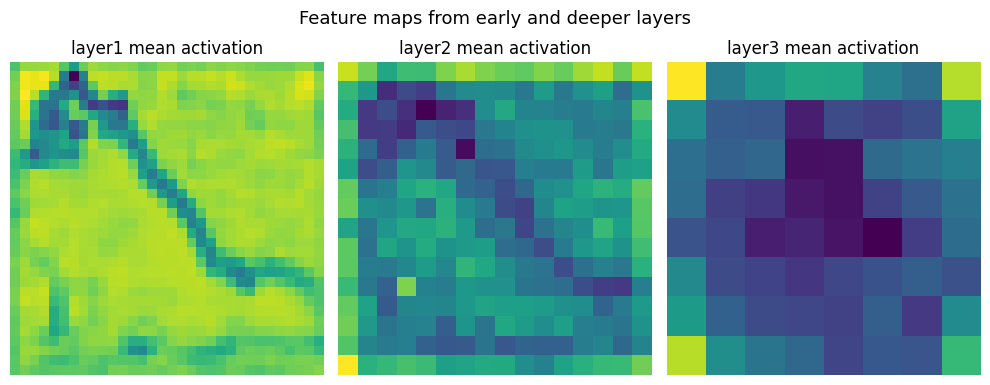

In [23]:
from torchvision import transforms
from PIL import Image
import torch

# Apply same preprocessing as before
prep_tfm = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

input_tensor = prep_tfm(img).unsqueeze(0).to(device)

# Define a hook to capture outputs of specific layers
feature_maps = {}

def get_activation(name):
    def hook(model, input, output):
        feature_maps[name] = output.detach().cpu()
    return hook

# Register hooks on two intermediate layers
model.layer1[0].conv1.register_forward_hook(get_activation("layer1"))
model.layer2[0].conv1.register_forward_hook(get_activation("layer2"))
model.layer3[0].conv1.register_forward_hook(get_activation("layer3"))

# Forward pass
with torch.no_grad():
    _ = model(input_tensor)

# Plot original image + selected feature maps
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes[0].imshow(img)
axes[0].set_title("Original image")
axes[0].axis("off")

display_order = ["layer1", "layer2", "layer3"]
for i, layer_name in enumerate(display_order, start=0):
    fmap = feature_maps[layer_name]
    fmap_mean = fmap[0].mean(dim=0)
    axes[i].imshow(fmap_mean, cmap="viridis")
    axes[i].set_title(f"{layer_name} mean activation")
    axes[i].axis("off")


plt.suptitle("Feature maps from early and deeper layers", fontsize=13)
plt.tight_layout()
plt.show()


> These visualizations show how convolutional layers transform the input image as it passes through the network.  
> Each map represents the **mean activation** across all feature channels for a specific layer — giving us a sense of how information evolves through the hierarchy.

**a. Early Layer (layer1)**  
- This layer captures **low-level visual patterns** such as edges, color transitions, and simple textures.  
- Notice the **sharp diagonal structure** resembling the outline of the dog — early filters focus on **local contrasts** and **edges**.  
- Activations here retain much of the **spatial detail** of the input image.

**b. Intermediate Layer (layer2)**  
- As we move deeper, the model starts combining multiple low-level features into **slightly more abstract patterns**.  
- The map looks more **blurred and coarser**, indicating that spatial details are being **compressed** while **semantic meaning increases**.  
- This layer may represent combinations like *fur texture*, *limb regions*, or *object boundaries*.

**c. Deeper Layer (layer3)**  
- The deepest map is much more **abstract** and **spatially coarse**.  
- The activations are concentrated in specific regions — the network is focusing on **high-level concepts** rather than edges or colors.  
- Such layers encode **object-level cues**, e.g., “dog presence,” “background context,” or “shape composition.”

**d. Hierarchical Insight**  
- CNNs transform the image from **pixels → edges → patterns → concepts**.  
- The gradual **loss of fine detail** and **increase in abstraction** mirrors how human vision works — early neurons detect edges, while deeper ones respond to objects.  
- Visualizing these feature maps helps us *see inside the black box*, revealing how convolutional layers progressively build up an understanding of the input.

**In short:**  
> - **Early layers** = "What am I looking at (edges, colors)?"  
> - **Middle layers** = "What patterns or parts are present?"  
> - **Deeper layers** = "What object or concept might this be?"


---

**✅ Code Task 11.1.7.1: Plot filters from the “second conv” (ResNet18’s early block)**

**Student instruction**: Using ResNet18, extract the weights of the next conv after conv1 (i.e., model.layer1[0].conv1) and visualize the first 32 filters in a grid.

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import models

CT_r18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to('cpu')
CT_conv2_filters = ...  # [C_out, C_in, k, k]

num = min(32, CT_conv2_filters.shape[0])
cols, rows = 8, (num + 7) // 8
plt.figure(figsize=(cols*1.6, rows*1.6))
for i in range(num):
    f = CT_conv2_filters[i]
    # collapse in_channels by taking mean for visualization
    f2 = f.mean(dim=0)
    f2 = (f2 - f2.min()) / (f2.max() - f2.min() + 1e-6)
    plt.subplot(rows, cols, i+1)
    plt.imshow(f2, cmap='viridis')
    plt.axis('off')
plt.suptitle("ResNet18 layer1[0].conv1 filters (mean over in-channels)")
plt.tight_layout()
plt.show()

**Instructor Solution**

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import models

CT_r18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to('cpu')
CT_conv2_filters = CT_r18.layer1[0].conv1.weight.detach().cpu()  # [C_out, C_in, k, k]

num = min(32, CT_conv2_filters.shape[0])
cols, rows = 8, (num + 7) // 8
plt.figure(figsize=(cols*1.6, rows*1.6))
for i in range(num):
    f = CT_conv2_filters[i]
    # collapse in_channels by taking mean for visualization
    f2 = f.mean(dim=0)
    f2 = (f2 - f2.min()) / (f2.max() - f2.min() + 1e-6)
    plt.subplot(rows, cols, i+1)
    plt.imshow(f2, cmap='viridis')
    plt.axis('off')
plt.suptitle("ResNet18 layer1[0].conv1 filters (mean over in-channels)")
plt.tight_layout()
plt.show()

In [ ]:
assert 'CT_conv2_filters' in globals(), "❌ Define CT_conv2_filters."
assert CT_conv2_filters.ndim == 4, "❌ CT_conv2_filters must be 4D (Cout, Cin, K, K)."
assert CT_conv2_filters.shape[2] == CT_conv2_filters.shape[3], "❌ Kernel must be square."
print("✅ CT_Task 3 checks passed.")

---

**✅ Code Task 11.1.7.2: First-conv feature responses on a different image**

**Student instruction**: Pick a different validation image index (not the one used earlier), preprocess it, pass through model.conv1 (ResNet18), and visualize 16 feature maps.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models

# Assume val_loader, IMAGENET_MEAN/STD exist (from earlier sections)
CT_img2_idx = 5  # choose any valid index in the first batch
CT_r18b = models.resnet18(weights=...).to('cpu')
CT_r18b.eval()

# Grab a batch and get a different validation image
CT_images, CT_labels = next(iter(...))
CT_x = CT_images[CT_img2_idx:CT_img2_idx+1]

# Compute feature maps
with torch.no_grad():
    CT_feat_maps1 = CT_r18b.conv1(...)[0]   # [C,H,W]
    
# plot CT_x
plt.figure(figsize=(4,4))
plt.imshow(CT_x[0].permute(1, 2, 0))
plt.title("Original Image (Input to Conv1)")
plt.axis("off")
plt.show()

# plot 16 channels
num = min(16, CT_feat_maps1.shape[0])
cols, rows = 8, (num + 7)//8
plt.figure(figsize=(cols*1.6, rows*1.6))
for i in range(num):
    plt.subplot(rows, cols, i+1)
    fm = CT_feat_maps1[i].cpu()
    plt.imshow(fm, cmap='gray')
    plt.axis('off')
plt.suptitle("First Conv Feature Responses (different image)")
plt.tight_layout()
plt.show()

**Instructor Solution**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2216995].


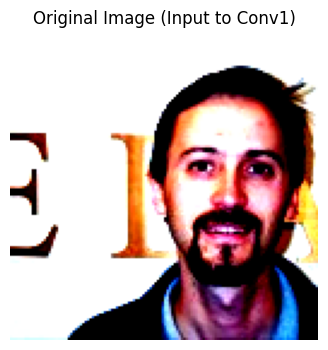

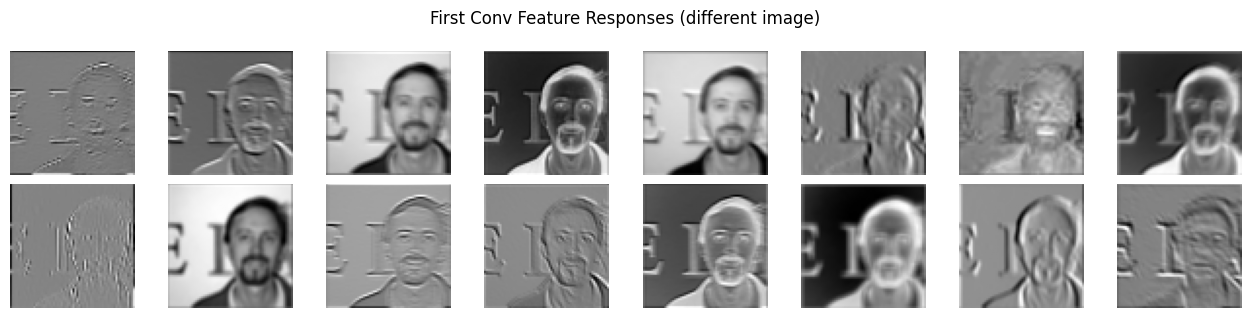

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models

CT_img2_idx = 5
CT_r18b = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to('cpu')
CT_r18b.eval()

# Get a different validation image
CT_images, CT_labels = next(iter(val_loader))
CT_x = CT_images[CT_img2_idx:CT_img2_idx+1]

# Compute feature maps
with torch.no_grad():
    CT_feat_maps1 = CT_r18b.conv1(CT_x)[0]   # [C,H,W]
    
# plot CT_x
plt.figure(figsize=(4,4))
plt.imshow(CT_x[0].permute(1, 2, 0))
plt.title("Original Image (Input to Conv1)")
plt.axis("off")
plt.show()

# plot feature maps
num = min(16, CT_feat_maps1.shape[0])
cols, rows = 8, (num + 7)//8
plt.figure(figsize=(cols*1.6, rows*1.6))
for i in range(num):
    plt.subplot(rows, cols, i+1)
    fm = CT_feat_maps1[i].cpu()
    plt.imshow(fm, cmap='gray')
    plt.axis('off')
plt.suptitle("First Conv Feature Responses (different image)")
plt.tight_layout()
plt.show()


In [ ]:
assert 'CT_feat_maps1' in globals(), "❌ CT_feat_maps1 not defined."
assert CT_feat_maps1.ndim == 3, "❌ Expect [C,H,W] feature maps."
assert CT_feat_maps1.shape[1] > 0 and CT_feat_maps1.shape[2] > 0, "❌ Spatial dims must be > 0."
print("✅ CT_Task 4 checks passed.")

---

**✅ Code Task 11.2.7.3: Mean activations for layer1, layer3, layer4**

**Student instruction**: Register forward hooks on `layer1[0].conv1`, `layer3[0].conv1`, and `layer4[0].conv1` of ResNet18. Using the same image as last code task, compute and plot the mean activation (across channels) for each of the three layers.

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import models

CT_r18c = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to('cpu').eval()
CT_feature_maps = {}

def CT_get_hook(name):
    def hook(m, inp, out):
        CT_feature_maps[name] = out.detach().cpu()
    return hook

# Register hooks
...
...
...

with torch.no_grad():
    _ = CT_r18c(CT_x)  # reuse CT_x from last code task

# Build dictionary of mean activations
CT_mean_act = {}
for k in ["layer1","layer3","layer4"]:
    fmap = ...
    CT_mean_act[k] = ...

# Plot 3 panels: layer1, layer3, layer4
...


**Instructor Solution**

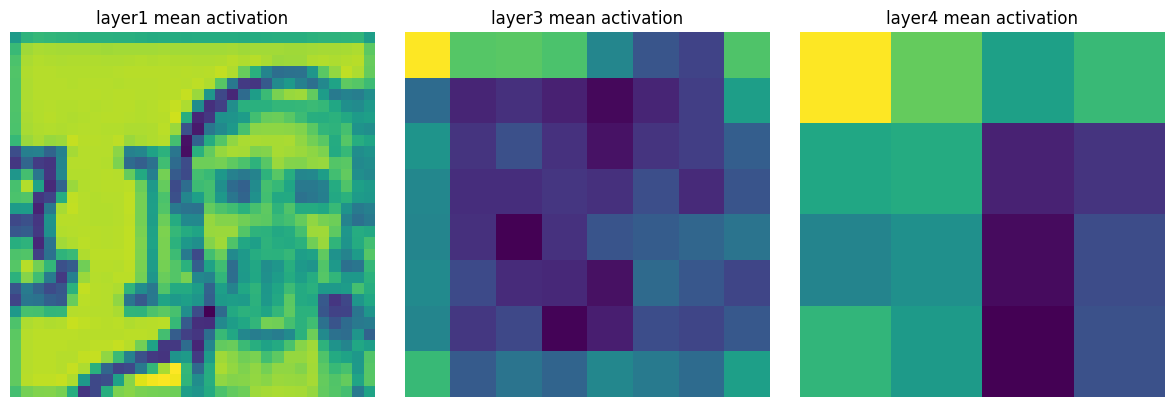

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import models

CT_r18c = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to('cpu').eval()
CT_feature_maps = {}

def CT_get_hook(name):
    def hook(m, inp, out):
        CT_feature_maps[name] = out.detach().cpu()
    return hook

h1 = CT_r18c.layer1[0].conv1.register_forward_hook(CT_get_hook("layer1"))
h3 = CT_r18c.layer3[0].conv1.register_forward_hook(CT_get_hook("layer3"))
h4 = CT_r18c.layer4[0].conv1.register_forward_hook(CT_get_hook("layer4"))

with torch.no_grad():
    _ = CT_r18c(CT_x)

CT_mean_act = {}
for k in ["layer1","layer3","layer4"]:
    fmap = CT_feature_maps[k][0]          # [C,H,W]
    CT_mean_act[k] = fmap.mean(dim=0)     # [H,W]

fig, axes = plt.subplots(1, 3, figsize=(12,4))
for i, k in enumerate(["layer1","layer3","layer4"]):
    axes[i].imshow(CT_mean_act[k], cmap='viridis')
    axes[i].set_title(f"{k} mean activation")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# cleanup hooks
h1.remove(); h3.remove(); h4.remove()


In [ ]:
assert 'CT_mean_act' in globals(), "❌ CT_mean_act dict missing."
for k in ["layer1","layer3","layer4"]:
    assert k in CT_mean_act, f"❌ Missing {k} in CT_mean_act."
    t = CT_mean_act[k]
    assert hasattr(t, 'shape') and t.ndim == 2, f"❌ {k} mean activation must be 2D."
    assert t.shape[0] > 0 and t.shape[1] > 0, f"❌ {k} mean activation spatial dims invalid."
print("✅ CT_Task 5 checks passed.")

---

### **8. Reflection: Feature Reuse and Domain Adaptation**

Let’s step back and reflect on what we’ve learned so far about **transfer learning** and **feature reuse**.

##### **a. Leveraging Prior Knowledge**

Training a deep convolutional neural network from scratch requires **millions of labeled images** and **weeks of computation**.  
However, pretrained models like ResNet-18 — trained on ImageNet’s 1.2 million diverse images — have already learned a powerful library of **visual features**.  

By reusing these pretrained filters, we effectively borrow the model’s *visual understanding* and apply it to our smaller dataset (Caltech-101).  
This is analogous to how we, as humans, can learn new tasks more easily when we already understand related ones — once we know what “edges,” “faces,” or “textures” look like, learning a new object class becomes much faster.

##### **b. Why We Freeze Layers Initially**

In this notebook, we **froze the convolutional backbone** — the part that extracts general features — and trained only a new classifier head.  
This strategy has several advantages:

- It drastically **reduces computation**, since we only update a few parameters.
- It **prevents overfitting**, especially when our dataset is small.
- It allows us to **reuse robust representations** that have already been optimized over millions of natural images.

This process is often called **feature extraction**, and it’s a foundational first step in transfer learning workflows.

##### **c. When Transfer Learning Excels — and When It Doesn’t**

Transfer learning is most effective when the **source and target domains** are *related* — for example:
- ImageNet → Caltech-101 → CIFAR → Oxford Pets → Plant Seedlings  
  (all are natural-image datasets with similar color, texture, and object structures)

However, if we try to reuse ImageNet features for **medical X-rays**, **microscopy**, or **satellite imagery**, performance might drop due to **domain mismatch**.  
In such cases, we often need **fine-tuning** — gradually unfreezing deeper layers and retraining them with a smaller learning rate to adapt the features to the new domain.

##### **d. Key Takeaways**

- **Early CNN layers** capture universal low-level features such as edges and colors.  
- **Middle and deep layers** capture more task-specific patterns and semantics.  
- **Freezing pretrained features** lets us train new tasks efficiently and robustly.  
- **Fine-tuning** deeper layers later allows the model to adapt to subtle domain differences.

##### **Reflective Prompts**

Before we move on to NB02, let’s pause to think critically:

1. What did we observe about how pretrained filters “see” the world?  
2. Why do we freeze early layers first instead of retraining the whole network immediately?  
3. Under what conditions might transfer learning *fail*?  
4. When and why might we decide to fine-tune deeper layers later?

> In the next notebook, we’ll put these insights into action — training our new classifier head on the Caltech-101 subset and observing how quickly it learns compared to training from scratch.


---

### **9. Saving for the Next Notebook**

Before we conclude, let’s save our **current model setup** and **class mappings**.  
Even though we haven’t trained the new classifier head yet, this checkpoint will allow us to continue seamlessly in **NB02**, where we’ll train the head while keeping the backbone frozen.

We’ll save:

1. The **model state dictionary** — containing the frozen pretrained backbone and the new randomly initialized classifier head.  
2. The **class-to-index mapping** — the dictionary used by our dataset and dataloaders to translate class names into numerical labels.

This ensures that when we reload the model later, our training labels will remain consistent, preventing any misalignment between classes and outputs.


**Save Model and Metadata**

In [23]:
import torch
import os

save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

checkpoint_path = os.path.join(save_dir, "resnet18_frozen_init.pth")
mapping_path = os.path.join(save_dir, "class_to_idx.pth")

# Save model state (untrained classifier + frozen backbone)
torch.save(model.state_dict(), checkpoint_path)

# Save class mapping
torch.save(train_ds.class_to_idx, mapping_path)

print(f"[saved] Model checkpoint: {checkpoint_path}")
print(f"[saved] Class mapping: {mapping_path}")


[saved] Model checkpoint: checkpoints\resnet18_frozen_init.pth
[saved] Class mapping: checkpoints\class_to_idx.pth


By saving both the model weights and the label mapping, we guarantee **continuity** between notebooks.  

In the next one, NB02, we will load this checkpoint, train only the new classifier head, and monitor its performance.

---

### **10. Summary and What Comes Next**

Let’s summarize what we achieved in this notebook and look ahead to the next stage of our journey.

**What We Learned**

- We built intuition for **transfer learning**, understanding how pretrained CNNs reuse learned features.
- We explored the **Caltech-101 subset**, setting up balanced train/validation/test splits.
- We built robust **data pipelines** with ImageNet-compatible normalization.
- We loaded and inspected a **pretrained ResNet-18**, interpreting its architecture and parameter hierarchy.
- We **froze the backbone** and replaced the classifier head for our custom 10-class dataset.
- We ran a **zero-shot forward pass** to verify data flow and output correctness.
- We visualized **filters and feature maps**, deepening our understanding of hierarchical feature extraction.
- We reflected on **feature reuse, domain adaptation**, and when fine-tuning might be necessary.
- Finally, we **saved our model checkpoint** and **class mappings** for future training.

**What Comes Next**

In **Notebook 2 (NB02: Feature Extraction Training)**, we will:

1. Load this checkpoint.  
2. Train the **new classifier head** while keeping the backbone frozen.  
3. Observe how quickly the model learns with minimal data.  
4. Evaluate accuracy, confusion matrix, and class-level performance.

By the end of NB02, we’ll have a strong appreciation for how pretrained features accelerate learning and when we might want to gradually unfreeze deeper layers for **fine-tuning** in later notebooks.
